In [2]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd

# Load the data
sentiment_data_financials = pd.read_csv('Sentiment_Results_Financials_Sum.csv')
sentiment_data_energy = pd.read_csv('Sentiment_Results_Energy_Sum.csv')
sentiment_data_technology = pd.read_csv('Sentiment_Results_Technology_Sum.csv')
returns_data = pd.read_csv('Portfolio_Returns_Linear.csv')

# Define sentiments and returns
sentiments = ['VADER Sentiment', 'FinBERT Sentiment', 'GPT Sentiment']
returns = ['Technology Return', 'Financials Return', 'Energy Return']
industries = ['Technology', 'Financials', 'Energy']
sentiment_data = [sentiment_data_technology, sentiment_data_financials, sentiment_data_energy]

# Models
models = ['RF', 'GB', 'VM']

# Number of folds
n_splits = 5
kf = KFold(n_splits=n_splits)

# Iterate through the industries, sentiments, and models
for industry, sentiment_df in zip(industries, sentiment_data):
    for sentiment in sentiments:
        for return_column in returns:
            if industry not in return_column:
                continue

            # Combine sentiment data with corresponding returns
            combined_data = sentiment_df.merge(returns_data[[return_column]], left_index=True, right_index=True)

            # Features and target variable
            X = combined_data[[sentiment]].values
            y = combined_data[return_column].values

            # Model selection
            for model_name in models:
                if model_name == 'RF':
                    model = RandomForestRegressor()
                elif model_name == 'GB':
                    model = GradientBoostingRegressor()
                elif model_name == 'VM':
                    model = SVR()

                # Cross-validation loop
                r2_scores = []
                for train_index, test_index in kf.split(X):
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    r2_scores.append(r2_score(y_test, y_pred))

                # Average R2 score for this model and sentiment
                avg_r2_score = np.mean(r2_scores)
                print(f'{industry} - {sentiment} {model_name} for {return_column}: Average R2 score across {n_splits} folds = {avg_r2_score}')


Technology - VADER Sentiment RF for Technology Return: Average R2 score across 5 folds = -0.22323782198818312
Technology - VADER Sentiment GB for Technology Return: Average R2 score across 5 folds = -0.2889280047352824
Technology - VADER Sentiment VM for Technology Return: Average R2 score across 5 folds = -0.32440213849614596
Technology - FinBERT Sentiment RF for Technology Return: Average R2 score across 5 folds = -0.2768139346625974
Technology - FinBERT Sentiment GB for Technology Return: Average R2 score across 5 folds = -0.2079538206153225
Technology - FinBERT Sentiment VM for Technology Return: Average R2 score across 5 folds = -0.32440213849614596
Technology - GPT Sentiment RF for Technology Return: Average R2 score across 5 folds = -0.20449952602277693
Technology - GPT Sentiment GB for Technology Return: Average R2 score across 5 folds = -0.22680471300477878
Technology - GPT Sentiment VM for Technology Return: Average R2 score across 5 folds = -0.32440213849614596
Financials - 

In [6]:
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import ParameterGrid


# Functions for feature engineering
def add_lagged_returns(data, returns_column, lags=5):
    for lag in range(1, lags + 1):
        data[f'{returns_column}_lag_{lag}'] = data[returns_column].shift(lag)
    return data.dropna()


def add_features(data, returns_column):
    data[f'{returns_column}_rolling_mean_5'] = data[returns_column].rolling(window=5).mean()
    data[f'{returns_column}_rolling_mean_10'] = data[returns_column].rolling(window=10).mean()
    data[f'{returns_column}_ewm_5'] = data[returns_column].ewm(span=5).mean()
    return data.dropna()


def add_difference(data, returns_column):
    data[f'{returns_column}_diff'] = data[returns_column].diff()
    return data.dropna()

# Load the data
sentiment_data_financials = pd.read_csv('Sentiment_Results_Financials_Sum.csv')
sentiment_data_energy = pd.read_csv('Sentiment_Results_Energy_Sum.csv')
sentiment_data_technology = pd.read_csv('Sentiment_Results_Technology_Sum.csv')
returns_data = pd.read_csv('Portfolio_Returns_Linear.csv')

# Define sentiments and returns
sentiments = ['VADER Sentiment', 'FinBERT Sentiment', 'GPT Sentiment']
returns = ['Technology Return', 'Financials Return', 'Energy Return']
industries = ['Technology', 'Financials', 'Energy']
sentiment_data = [sentiment_data_technology, sentiment_data_financials, sentiment_data_energy]

# Define models and hyperparameter grids
models = [
    ('RF', RandomForestRegressor(random_state=42), {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    ('GB', GradientBoostingRegressor(random_state=42), {
        # same hyperparameters as RF...
    }),
    ('VM', SVR(), {
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.5],
        'kernel': ['linear', 'rbf']
    })
]

# Number of splits
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
# Define lags to test
lags_to_test = [1, 2, 3, 4, 5]
# Load best parameters
with open('best_parameters.json', 'r') as file:
    best_parameters = json.load(file)

# Iterate through the sentiments, industries, and models
for sentiment in sentiments:
    for return_column in returns:
        industry = return_column.split(' ')[0]
        sentiment_df = sentiment_data[industries.index(industry)] # Assuming sentiment_data is a list of DataFrames

        # Combine sentiment data with corresponding returns
        combined_data = sentiment_df.merge(returns_data[[return_column, 'Date']], on='Date')
        combined_data['Date'] = pd.to_datetime(combined_data['Date']) # Ensure 'Date' is in datetime format
        combined_data = combined_data.sort_values(by='Date')

        # Features and target variable
        X = combined_data[[sentiment]]
        y = combined_data[return_column]

        for lag in lags_to_test:
            lagged_data = combined_data.copy()
            lagged_data = add_lagged_returns(lagged_data, return_column, lags=lag)
            lagged_data = add_features(lagged_data, return_column)
            lagged_data = add_difference(lagged_data, return_column)


            # Split into X and y
            X = lagged_data.drop(columns=[return_column, 'Date'])
            y = lagged_data[return_column]

            # Split into training and testing based on date
            split_date = '2022-09-01'
            train_data = lagged_data[lagged_data['Date'] < split_date]
            test_data = lagged_data[lagged_data['Date'] >= split_date]
            X_train, y_train = train_data.drop(columns=[return_column, 'Date']), train_data[return_column]
            X_test, y_test = test_data.drop(columns=[return_column, 'Date']), test_data[return_column]

            for model_name, model, param_grid in models:
                # Define the pipeline
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('model', model)
                ])

                # Iterate through the parameter grid
                for params in ParameterGrid(param_grid):
                    # Set the parameters
                    pipeline.set_params(**{'model__' + key: value for key, value in params.items()})

                    # Fit the model
                    pipeline.fit(X_train, y_train)

                    # Make predictions
                    predictions = pipeline.predict(X_test)

                    # Calculate R2 score
                    r2 = r2_score(y_test, predictions)

                    # You may also want to calculate other metrics, such as mean squared error
                    mse = mean_squared_error(y_test, predictions)

                    # Print or save the results as needed
                    print(f"Model: {model_name}, Parameters: {params}, R2: {r2}, MSE: {mse}")


Model: RF, Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}, R2: 0.8502940377243466, MSE: 6.0493229001117946e-05
Model: RF, Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, R2: 0.8492857600325974, MSE: 6.090065414555807e-05
Model: RF, Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}, R2: 0.8455685861192413, MSE: 6.240269086713892e-05
Model: RF, Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}, R2: 0.8440873100549242, MSE: 6.300124533224179e-05
Model: RF, Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}, R2: 0.8451964150098326, MSE: 6.255307787782865e-05
Model: RF, Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}, R2: 0.8414086879353322, MSE: 6.408362374139011e-05
Model: RF, Parameters: 

/var/folders/_2/9fsr1fps4lj4bw4c5gh4y3km0000gn/T/ipykernel_52601/222321233.py:188: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Sector', y='R2', hue='Sentiment', data=subset, ax=axes[i], order=sectors_order, ci=None, palette=colors) # <--- Hier das palette-Argument hinzugefügt
/var/folders/_2/9fsr1fps4lj4bw4c5gh4y3km0000gn/T/ipykernel_52601/222321233.py:188: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Sector', y='R2', hue='Sentiment', data=subset, ax=axes[i], order=sectors_order, ci=None, palette=colors) # <--- Hier das palette-Argument hinzugefügt
/var/folders/_2/9fsr1fps4lj4bw4c5gh4y3km0000gn/T/ipykernel_52601/222321233.py:188: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Sector', y='R2', hue='Sentiment', data=subset, ax=axes[i], order=sectors_order, ci=None, palette=colors) # <--- Hier das 

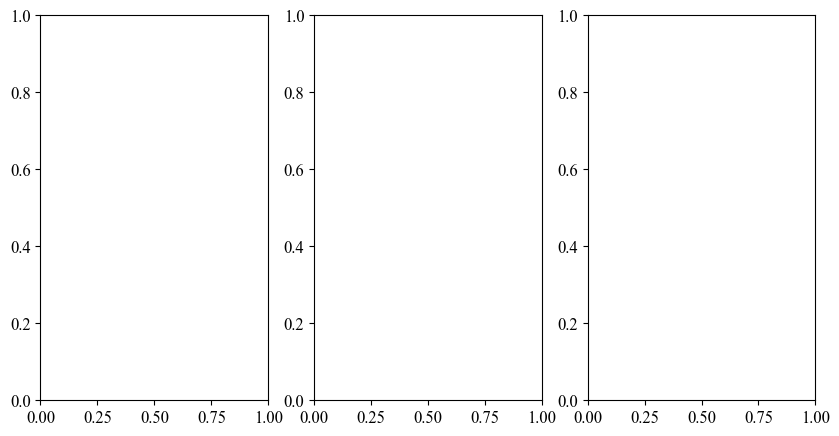

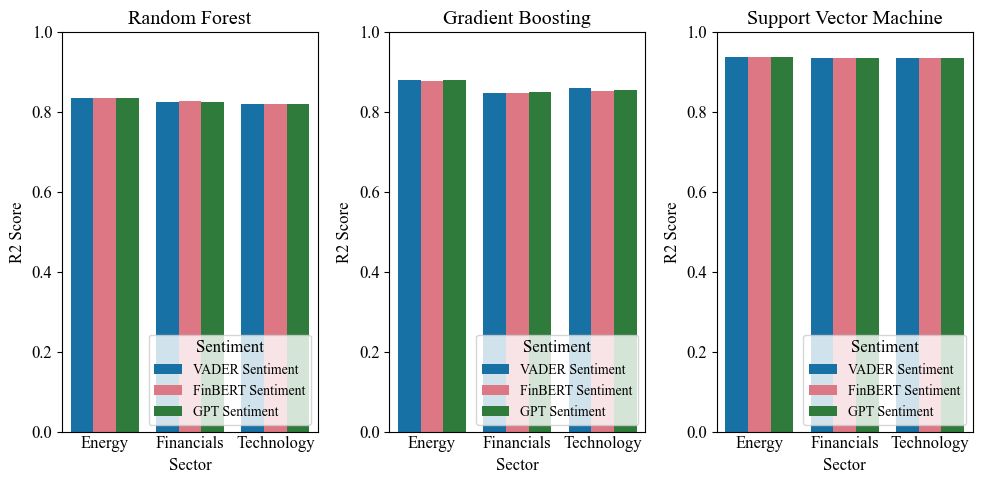

                                              MSE                        \
Sector                                     Energy Financials Technology   
Sentiment         Model                                                   
FinBERT Sentiment Gradient Boosting      0.000054   0.000045   0.000061   
                  Random Forest          0.000074   0.000052   0.000074   
                  Support Vector Machine 0.000027   0.000018   0.000025   
GPT Sentiment     Gradient Boosting      0.000053   0.000044   0.000059   
                  Random Forest          0.000075   0.000052   0.000073   
                  Support Vector Machine 0.000027   0.000018   0.000025   
VADER Sentiment   Gradient Boosting      0.000053   0.000045   0.000057   
                  Random Forest          0.000074   0.000052   0.000074   
                  Support Vector Machine 0.000027   0.000018   0.000025   

                                               R2                        
Sector                   

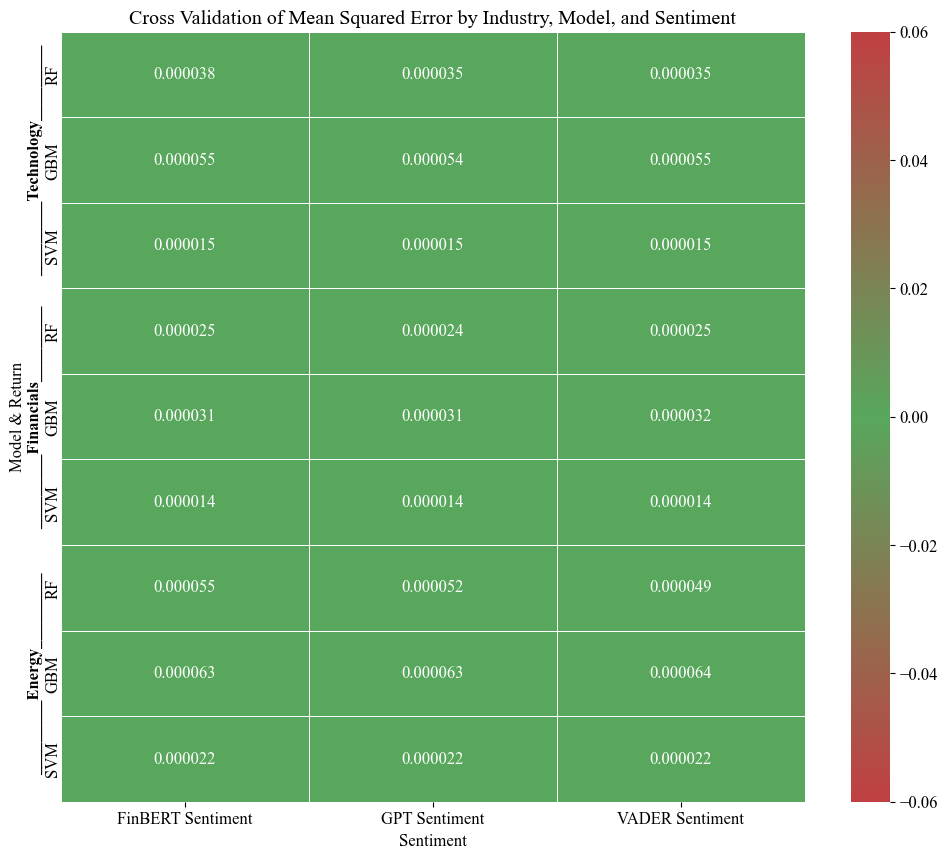

In [95]:
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib as mpl
# Set the global font to be Times New Roman, size 10
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12

# Functions for feature engineering
def add_lagged_returns(data, returns_column, lags=5):
    for lag in range(1, lags + 1):
        data[f'{returns_column}_lag_{lag}'] = data[returns_column].shift(lag)
    return data.dropna()


def add_features(data, returns_column):
    data[f'{returns_column}_rolling_mean_5'] = data[returns_column].rolling(window=5).mean()
    data[f'{returns_column}_rolling_mean_10'] = data[returns_column].rolling(window=10).mean()
    data[f'{returns_column}_ewm_5'] = data[returns_column].ewm(span=5).mean()
    return data.dropna()


def add_difference(data, returns_column):
    data[f'{returns_column}_diff'] = data[returns_column].diff()
    return data.dropna()

# Load the data
sentiment_data_financials = pd.read_csv('Sentiment_Results_Financials_Sum.csv')
sentiment_data_energy = pd.read_csv('Sentiment_Results_Energy_Sum.csv')
sentiment_data_technology = pd.read_csv('Sentiment_Results_Technology_Sum.csv')
returns_data = pd.read_csv('Portfolio_Returns_Linear.csv')

# Define sentiments and returns
sentiments = ['VADER Sentiment', 'FinBERT Sentiment', 'GPT Sentiment']
returns = ['Technology Return', 'Financials Return', 'Energy Return']
industries = ['Technology', 'Financials', 'Energy']
sentiment_data = [sentiment_data_technology, sentiment_data_financials, sentiment_data_energy]

# Define models and hyperparameter grids
models = [
    ('RF', RandomForestRegressor(random_state=42), {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    ('GB', GradientBoostingRegressor(random_state=42), {
        # same hyperparameters as RF...
    }),
    ('VM', SVR(), {
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.5],
        'kernel': ['linear', 'rbf']
    })
]

# Number of splits
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
# Define lags to test
lags_to_test = [1, 2, 3, 4, 5]
# Load best parameters
with open('best_parameters.json', 'r') as file:
    best_parameters = json.load(file)

# Empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Sentiment', 'Return', 'Parameters', 'R2', 'MSE'])
# Empty list to store the results
results = []

# Iterate through the sentiments, industries, and models
for sentiment in sentiments:
    for return_column in returns:
        industry = return_column.split(' ')[0]
        sentiment_df = sentiment_data[industries.index(industry)] # Assuming sentiment_data is a list of DataFrames

        # Combine sentiment data with corresponding returns
        combined_data = sentiment_df.merge(returns_data[[return_column, 'Date']], on='Date')
        combined_data['Date'] = pd.to_datetime(combined_data['Date']) # Ensure 'Date' is in datetime format
        combined_data = combined_data.sort_values(by='Date')

        for lag in lags_to_test:
            lagged_data = combined_data.copy()
            lagged_data = add_lagged_returns(lagged_data, return_column, lags=lag)
            lagged_data = add_features(lagged_data, return_column)
            lagged_data = add_difference(lagged_data, return_column)

            # Split into X and y
            X = lagged_data.drop(columns=[return_column, 'Date'])
            y = lagged_data[return_column]

            for model_name, model, _ in models:
                # Get the best parameters for this sentiment, return, and lag
                best_params = best_parameters[sentiment][return_column][str(lag)][model_name]

                for train_index, test_index in tscv.split(X):
                    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                    # Define the pipeline
                    pipeline = Pipeline([
                        ('scaler', StandardScaler()),
                        ('model', model)
                    ])

                    # Set the parameters
                    pipeline.set_params(**{'model__' + key: value for key, value in best_params.items()})

                    # Fit the model
                    pipeline.fit(X_train, y_train)

                    # Make predictions
                    predictions = pipeline.predict(X_test)

                    # Calculate R2 score and MSE
                    r2 = r2_score(y_test, predictions)
                    mse = mean_squared_error(y_test, predictions)

                    # Append results to the results list
                    results.append({
                        'Sentiment': sentiment,
                        'Return': return_column,
                        'Lag': lag,
                        'Model': model_name,
                        'R2': r2,
                        'MSE': mse
                    })

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)


# Define a color map for the R2 values
cmap_r2 = LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])

# Define a mapping from abbreviations to full model names
model_name_mapping = {
    'RF': 'Random Forest',
    'GB': 'Gradient Boosting',
    'VM': 'Support Vector Machine'
}

# Replace the abbreviations with full model names in the 'Model' column
results_df['Model'] = results_df['Model'].map(model_name_mapping)

# Defining the order of the sectors
sectors_order = ['Energy', 'Financials', 'Technology']
models_full_names = ['Random Forest', 'Gradient Boosting', 'Support Vector Machine']

# You might want to modify the results DataFrame to match the structure of model_sector_df in your given code
# Assuming model_sector_df is a modified version of results_df
model_sector_df = results_df.copy()
model_sector_df['Sector'] = model_sector_df['Return'].apply(lambda x: x.split(' ')[0])

fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Remove sharey=True

# Beispiel für ein benutzerdefiniertes Farbschema:
colors = ["#0077BB", "#EE6677", "#228833"]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Plot the bar plots
for i, model in enumerate(models_full_names):
    subset = model_sector_df[model_sector_df['Model'] == model]
    sns.barplot(x='Sector', y='R2', hue='Sentiment', data=subset, ax=axes[i], order=sectors_order, ci=None, palette=colors) # <--- Hier das palette-Argument hinzugefügt
    axes[i].set_title(f'{model}')
    axes[i].set_ylim(0, 1)
    axes[i].set_xlabel('Sector')
    axes[i].set_ylabel('R2 Score')  # Set y-label for each subplot
    axes[i].legend(loc='lower right', title='Sentiment', fontsize='small')
    axes[i].tick_params(axis='x', length=0)  # Remove x-tick marks but retain labels


plt.tight_layout()
plt.savefig('Graphics/4 Validation_R2_Scores.png')
plt.savefig('Graphics/4 Validation_R2_Scores.pdf', bbox_inches='tight')
plt.show()




# Add the 'Sector' column to results_df
results_df['Sector'] = results_df['Return'].apply(lambda x: x.split(' ')[0])

# Now you can group by 'Sentiment', 'Model', and 'Sector'
grouped_results = results_df.groupby(['Sentiment', 'Model', 'Sector']).agg({'R2': 'mean', 'MSE': 'mean'}).reset_index()


# Reshaping the DataFrame to a wide format
pivot_results = grouped_results.pivot_table(index=['Sentiment', 'Model'], columns='Sector', values=['R2', 'MSE'], aggfunc='first')

# Printing the DataFrame with the desired columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # No limit on the width of each row
print(pivot_results)







# Define the custom colors and thresholds
colors = ["#c03f43", "#58a75d", "#c03f43"] # Red to white to blue
custom_cmap = LinearSegmentedColormap.from_list("custom", colors, N=256)

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(mse_matrix, cmap=custom_cmap, annot=True, linewidths=0.5, fmt='.6f', ax=ax, vmin=-0.06, vmax=0.06) # Modify vmin and vmax here


# Hide the default y-ticks
ax.yaxis.set_ticks([])

# Define a function to add model labels
def add_model_labels(models, start_pos):
    for i, model in enumerate(models):
        ax.text(-0.03, start_pos + i + 0.5, model, rotation=90, va='center', ha='center')

# Add industry and model labels
start_pos = 0
models_per_industry = len(models) # Replace this with the correct value
for industry in industries:
    ax.text(-0.1, start_pos + models_per_industry / 2, f"_________{industry}_________", rotation=90, va='center', ha='center', weight='bold')
    add_model_labels(models_repeated[start_pos:start_pos + models_per_industry], start_pos)
    start_pos += models_per_industry

# Set x-axis labels
x_labels = mse_matrix.columns.get_level_values('Sentiment')
ax.set_xticklabels(x_labels, rotation=0, ha='center')

# Add y-axis label to the far left
plt.ylabel('Model & Return', labelpad=25)

# Set title and axis labels
plt.title('Cross Validation of Mean Squared Error by Industry, Model, and Sentiment')
plt.xlabel('Sentiment')

# Save the plot
plt.savefig('Graphics/4 Validation_MSE_Matrix.png')
plt.savefig('Graphics/4 Validation_MSE_Matrix.pdf', bbox_inches='tight')

plt.show()




